In [142]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [65]:
apt1 = cv2.imread('../images/apt1.jpg')
apt2 = cv2.imread('../images/apt2.jpg')
aloe1 = cv2.imread('../images/aloe1.png')
aloe2 = cv2.imread('../images/aloe2.png')
correspondences = np.genfromtxt('../images/corresp.txt', dtype=float, skip_header=1)

In [94]:
def computeFundMat(im1,im2,corr1,corr2):

    # Center the image data at the origin, and scale it so  
    # the mean squared distance between the origin and 
    # the data points is 2 pixels
    center_corr1 = corr1 - np.mean(corr1, axis=0)
    center_corr2 = corr2 - np.mean(corr2, axis=0)
    std1 = np.std(center_corr1, axis=0)
    std2 = np.std(center_corr2, axis=0)
    n_corr1 = center_corr1 / std1
    n_corr2 = center_corr2 / std2
    uv = center_corr1 * np.sqrt(2)
    uv_prime = center_corr2 * np.sqrt(2)

    # construct A
    A = []
    A.append(uv[:, 0] * uv_prime[:, 0]) # u u'
    A.append(uv[:, 0] * uv_prime[:, 1]) # u v'
    A.append(uv[:, 0])                  # u
    A.append(uv[:, 1] * uv_prime[:, 0]) # v u'
    A.append(uv[:, 1] * uv_prime[:, 1]) # v v'
    A.append(uv[:, 1])                  # v
    A.append(uv_prime[:, 0])            # u'
    A.append(uv_prime[:, 1])            # v' 
    A.append(np.ones(uv[:, 0].shape))

    # transpose for right shape
    A = np.stack(A).T

    # Perform SVD on A
    U, D, Vt = np.linalg.svd(A)

    # Get the fundamental matrix from the last column of V
    F = Vt[-1].reshape(3,3)

    # rank 2 constraint
    U, D, Vt = np.linalg.svd(F)
    D[-1] = 0
    F = np.dot(U, np.dot(np.diag(D), Vt))

    # Normalize fundamental matrix
    F = F / F[-1][-1]

    return F

def display_correspondences(im1,im2,corr1,corr2, ax):

    ## Insert correspondences
    print("Display correspondences")
    ax[0].imshow(im1[:, :, [2, 1, 0]])
    ax[0].scatter(corr1[:, 0], corr1[:, 1], color="red")
    ax[1].imshow(im2[:, :, [2, 1, 0]])
    ax[1].scatter(corr2[:, 0], corr2[:, 1], color="red")

(450, 300, 3)
Compute Fundamental Matrix
Display correspondences


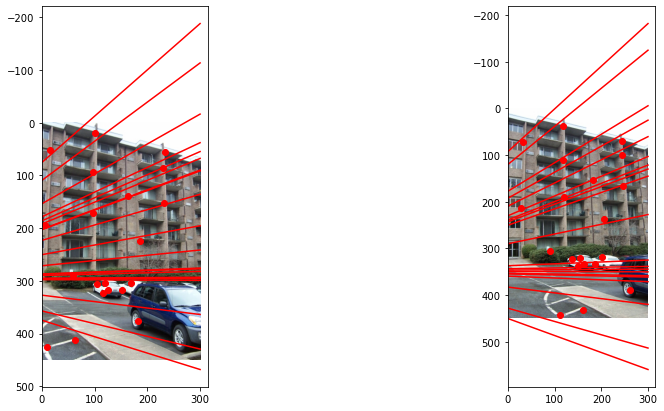

In [203]:
def drawEpipolar(im1,im2,points1,points2,F, ax):

    # ensure points are homogenous coords
    points1 = np.column_stack((points1, np.ones(points1.shape[0])))
    points2 = np.column_stack((points2, np.ones(points2.shape[0])))

    for i in range(points1.shape[0]):
        F_T_x = F @ points1[i]
        F_x_prime = F.T @ points2[i]

        # Normalize lines
        F_T_x = F_T_x / np.linalg.norm(F_T_x, axis=0)
        F_x_prime = F_x_prime / np.linalg.norm(F_x_prime, axis=0)
    
        a1, b1, c1 = F_T_x
        a2, b2, c2 = F_x_prime
        x = np.linspace(0, im1.shape[1])
        # because epipolar lines are represented as ax + by + c
        y1 = -(c1 + a1*x) / b1
        y2 = -(c2 + a2*x) / b2
        ax[0].plot(x, y1, 'r')
        ax[1].plot(x, y2, 'r')

def question_q1_q2(im1,im2,correspondences):
    ## Compute and print Fundamental Matrix using the normalized corresponding points method.
    ## Display corresponding points and Epipolar lines
    corr1 = correspondences[:, :2]
    corr2 = correspondences[:, 2:]
    print(im1.shape)

    _, ax = plt.subplots(1, 2, figsize=(15,7))


    print("Compute Fundamental Matrix")
    F = computeFundMat(im1.copy(), im2.copy(), corr1, corr2)
    display_correspondences(im1.copy(), im2.copy(), corr1, corr2, ax)
    drawEpipolar(im1.copy(), im2.copy(), corr1, corr2, F, ax)


question_q1_q2(apt1,apt2,correspondences)


Lines seem to be off, points seem to be fine

Compute Disparity Map


100%|██████████| 390/390 [00:08<00:00, 45.26it/s]


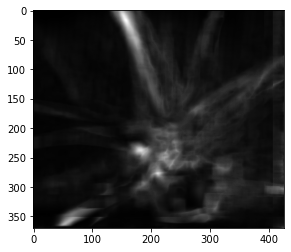

In [199]:
def question_q3(im1, im2):
    ## compute disparity map
    print("Compute Disparity Map")

    window_size = 20
    bigger_window_size = 50
    img1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    padding_big = bigger_window_size//2 
    padding_small = window_size // 2

    # padding of disparity map for sliding window approach
    img1_gray = np.pad(img1_gray, pad_width=padding_big, mode="constant")
    img2_gray = np.pad(img2_gray, pad_width=padding_small, mode="constant")

    disparity_map_padded = np.zeros((img2_gray.shape))
    # for Efficiency I implemented a sliding window over a sliding window
    for i in tqdm(range(img2_gray.shape[0])):
        for j in range(img2_gray.shape[1]):
            window = img2_gray[i: i + window_size, j: j + window_size]
            bigger_window = img1_gray[i: i + bigger_window_size, j: j + bigger_window_size]

            disparity = cv2.matchTemplate(bigger_window, window, cv2.TM_SQDIFF_NORMED)

            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(disparity)
            # min value corresponds to the best match
            disparity_map_padded[i, j] = min_val
            # print(min_loc, max_loc)
            # print(disparity.shape)

    disparity_map = disparity_map_padded[padding_small:-padding_small, padding_small:-padding_small]
    max_val = disparity_map.max()
    min_val = disparity_map.min()
    disparity_map = (disparity_map - min_val) / (max_val - min_val)

    # Display the disparity map
    plt.imshow(disparity_map, cmap="gray")

question_q3(aloe1,aloe2)


Fundamental Matrix
Compute Rectification
Display Warped Images


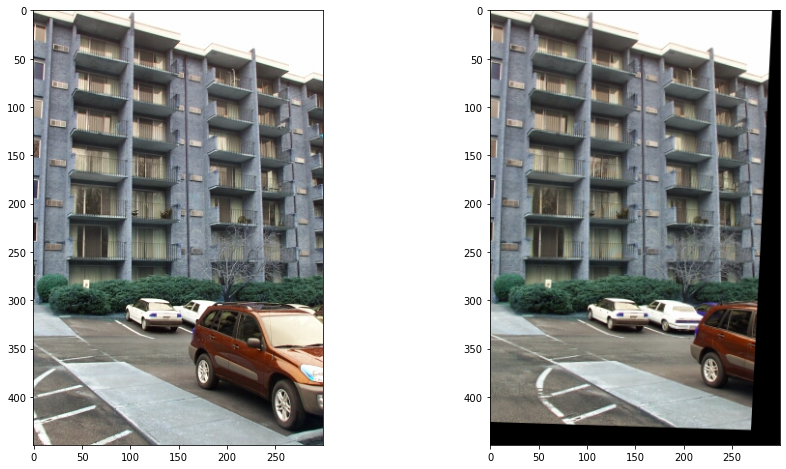

In [215]:

def question_q4(im1, im2, correspondences):
    corr1 = correspondences[:, :2]
    corr2 = correspondences[:, 2:]
    ## Perform Image rectification

    ### usage of either one is permitted
    print ("Fundamental Matrix")
    fundMat = np.array([
        [-1.78999e-7, 5.70878e-6, -0.00260653],
        [-5.71422e-6, 1.63569e-7, -0.0068799], 
        [0.00253316, 0.00674493, 0.191989]
        ]) ## Insert the given matrix
    fundMat = computeFundMat(im1.copy(),im2.copy(),corr1,corr2)

    ## Compute Rectification or Homography
    print("Compute Rectification")
    ## Apply Homography

    
    # Detect keypoints and compute descriptors using SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    # Match keypoints using BFMatcher
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)

    # Find the homography matrix
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp the second image using the homography matrix
    img2_rectified = cv2.warpPerspective(im2, M, (im1.shape[1], im1.shape[0]))


    print("Display Warped Images")
    _, ax = plt.subplots(1, 2, figsize=(15,8))
    ax[0].imshow(im1)
    ax[1].imshow(img2_rectified)


question_q4(apt1,apt2,correspondences)